# NYC Subway 

> In this notebook, we're going to analyze the NYC subway dataset. 

> This dataset contains information of subway such as: number of entries of subway at times of the day as well as weather conditions.

# Import Lib


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error, mean_absolute_error

# Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/nyc_subway.csv')

> Let's take a look on our data!

In [ ]:
data.head()

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,weekday,station,latitude,longitude,conds,fog,precipi,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
0,R003,05-01-11,00:00:00,4388333,2911002,0.0,0.0,2011-05-01 00:00:00,0,6,0,CYPRESS HILLS,40.689945,-73.872564,Clear,0,0.0,30.22,0,55.9,3.5,0.0,30.258,55.98,7.86,40.700348,-73.887177
1,R003,05-01-11,04:00:00,4388333,2911002,0.0,0.0,2011-05-01 04:00:00,4,6,0,CYPRESS HILLS,40.689945,-73.872564,Partly Cloudy,0,0.0,30.25,0,52.0,3.5,0.0,30.258,55.98,7.86,40.700348,-73.887177
2,R003,05-01-11,12:00:00,4388333,2911002,0.0,0.0,2011-05-01 12:00:00,12,6,0,CYPRESS HILLS,40.689945,-73.872564,Mostly Cloudy,0,0.0,30.28,0,62.1,6.9,0.0,30.258,55.98,7.86,40.700348,-73.887177
3,R003,05-01-11,16:00:00,4388333,2911002,0.0,0.0,2011-05-01 16:00:00,16,6,0,CYPRESS HILLS,40.689945,-73.872564,Mostly Cloudy,0,0.0,30.26,0,57.9,15.0,0.0,30.258,55.98,7.86,40.700348,-73.887177
4,R003,05-01-11,20:00:00,4388333,2911002,0.0,0.0,2011-05-01 20:00:00,20,6,0,CYPRESS HILLS,40.689945,-73.872564,Mostly Cloudy,0,0.0,30.28,0,52.0,10.4,0.0,30.258,55.98,7.86,40.700348,-73.887177


In [ ]:
data.shape

(42649, 27)

> Our data has 27 features and more than 40.000 records

In [ ]:
data.columns

Index(['UNIT', 'DATEn', 'TIMEn', 'ENTRIESn', 'EXITSn', 'ENTRIESn_hourly',
       'EXITSn_hourly', 'datetime', 'hour', 'day_week', 'weekday', 'station',
       'latitude', 'longitude', 'conds', 'fog', 'precipi', 'pressurei', 'rain',
       'tempi', 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi',
       'meanwspdi', 'weather_lat', 'weather_lon'],
      dtype='object')

`UNIT`: code of subway

`DATEn`: date of the record 

`TIMEn`: time of the record

`datetime`: datetime of the record

`ENTRIESn_hourly`: the average number of entries per hour

`EXITSn_hourly`: the average number of exits per hour

`hour`: hour of day

`day_week`: day of the week

`weekday`: whether is weekend or not

`station`: name of the station

`latitude`: latitude of the station

`longitude`: longitude of the station 

`conds`: conditions of the weather

`fog`: has fog or not

`precipitation`: the rate of precipitation

`rain`: its rain or not

`tempi`: tempurature

`pressurei`: the pressure of air

`weather_lat` and `weather_lon`: location of the weather measuring 


> I'm gonna drop some features which are not helpful: `longtitude`, `latitude`, `weather_lat`, `weather_lon` because this analyst focus on anaylysis the relationship among amount of subway ridership, datetime and weather conditions

In [ ]:
data = data.drop(columns=['longitude', 'latitude', 'weather_lat', 'weather_lon'])

In [ ]:
data.shape

(42649, 23)

> See data type:

In [ ]:
data.dtypes

UNIT                object
DATEn               object
TIMEn               object
ENTRIESn             int64
EXITSn               int64
ENTRIESn_hourly    float64
EXITSn_hourly      float64
datetime            object
hour                 int64
day_week             int64
weekday              int64
station             object
conds               object
fog                  int64
precipi            float64
pressurei          float64
rain                 int64
tempi              float64
wspdi              float64
meanprecipi        float64
meanpressurei      float64
meantempi          float64
meanwspdi          float64
dtype: object

> Only `UNIT`, `DATEn`, `TIMEn`, `datetime` and `conds` are categorical variables. 

> The rests are numerical variables

### Non-graphical Univariate Analysis

> `UNIT`

In [ ]:
data['UNIT'].value_counts()

R057    186
R111    186
R137    186
R030    186
R172    186
       ... 
R453    162
R277    160
R260    156
R295    138
R459     88
Name: UNIT, Length: 240, dtype: int64

> `conds`

In [ ]:
data['conds'].value_counts()

Clear               13594
Overcast            11975
Mostly Cloudy        6491
Scattered Clouds     3489
Partly Cloudy        2220
Light Rain           1880
Haze                 1345
Rain                  961
Light Drizzle         335
Heavy Rain            288
Fog                    47
Mist                   24
Name: conds, dtype: int64

Most of times the weather is clear and overcast. 

> Now, we're gonna see the values distribution of features

In [ ]:
data.describe()

,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,hour,day_week,weekday,fog,precipi,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi
count,4.264900e+04,4.264900e+04,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000,42649.000000
mean,2.812486e+07,1.986993e+07,1886.589955,1361.487866,10.046754,2.905719,0.714436,0.009824,0.004618,29.971096,0.224741,63.103780,6.927872,0.004618,29.971096,63.103780,6.927872
std,3.043607e+07,2.028986e+07,2952.385585,2183.845409,6.938928,2.079231,0.451688,0.098631,0.025832,0.137942,0.417417,8.455597,4.510178,0.016344,0.131158,6.939011,3.179832
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.550000,0.000000,46.900000,0.000000,0.000000,29.590000,49.400000,0.000000
25%,1.039762e+07,7.613712e+06,274.000000,237.000000,4.000000,1.000000,0.000000,0.000000,0.000000,29.890000,0.000000,57.000000,4.600000,0.000000,29.913333,58.283333,4.816667
50%,1.818389e+07,1.331609e+07,905.000000,664.000000,12.000000,3.000000,1.000000,0.000000,0.000000,29.960000,0.000000,61.000000,6.900000,0.000000,29.958000,60.950000,6.166667
75%,3.263049e+07,2.393771e+07,2255.000000,1537.000000,16.000000,5.000000,1.000000,0.000000,0.000000,30.060000,0.000000,69.100000,9.200000,0.000000,30.060000,67.466667,8.850000
max,2.357746e+08,1.493782e+08,32814.000000,34828.000000,20.000000,6.000000,1.000000,1.000000,0.300000,30.320000,1.000000,86.000000,23.000000,0.157500,30.293333,79.800000,17.083333


In [ ]:
sum(data['ENTRIESn_hourly'] == 0)

897

> Our data seems correctly except there's are 897 records has zero value of `ENTRIESn_hourly` and `EXITSn_hourly` maybe due to maintenance. 
> I will drop these records


In [ ]:
data = data.loc[(data['ENTRIESn_hourly']>0)]

In [ ]:
data.shape

(41752, 23)

In [ ]:
data.isnull().sum()

UNIT               0
DATEn              0
TIMEn              0
ENTRIESn           0
EXITSn             0
ENTRIESn_hourly    0
EXITSn_hourly      0
datetime           0
hour               0
day_week           0
weekday            0
station            0
conds              0
fog                0
precipi            0
pressurei          0
rain               0
tempi              0
wspdi              0
meanprecipi        0
meanpressurei      0
meantempi          0
meanwspdi          0
dtype: int64

> Luckily, There's no missing value!

### Graphical Univariate Analysis

> We're gonna visualize data to have better observation!

Text(0, 0.5, 'Number of entries')

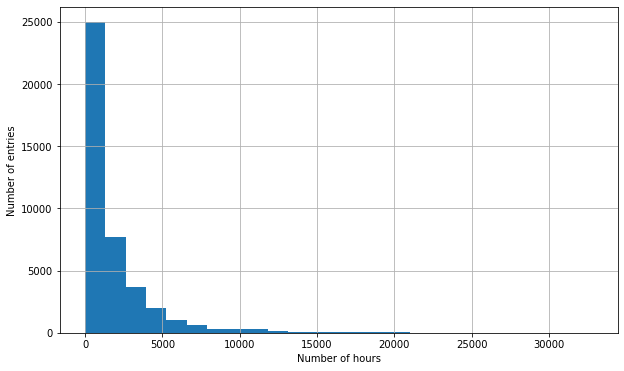

In [ ]:
data['ENTRIESn_hourly'].hist(bins=25, figsize=(10,6))
plt.xlabel('Number of hours')
plt.ylabel('Number of entries')

Text(0, 0.5, 'Number of entries')

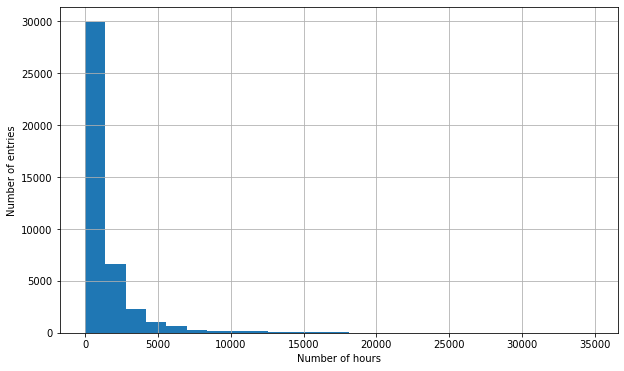

In [ ]:
data['EXITSn_hourly'].hist(bins=25, figsize=(10,6))
plt.xlabel('Number of hours')
plt.ylabel('Number of entries')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


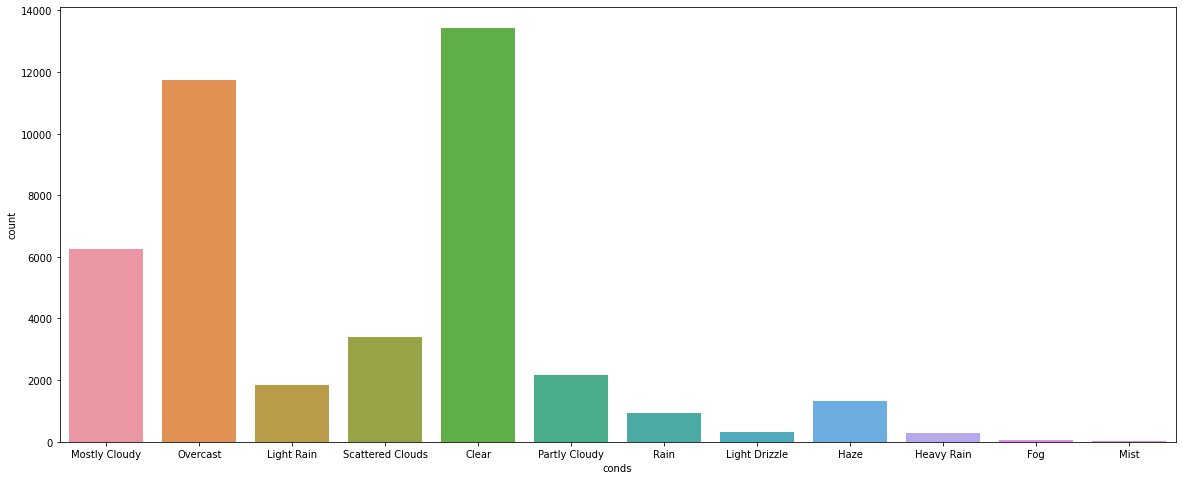

In [ ]:
fig_dims = (20, 8)

fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['conds'], ax=ax)


## Hypothesis Testing

> Above are general views of our data

> Now, we will down deeper to get the sight of data

> To do this, I will make some assumptions



### 1. The rainning effects the amount of subway ridership 

> Null hypotheis: There's no significant different between the means of two group: entries with rain and entries without rain

> My hypothesis: There's a significant different between the means of two group. 

In [ ]:
rain_data = data[data['rain']==1][['ENTRIESn_hourly']]
non_rain_data = data[data['rain']==0][['ENTRIESn_hourly']]

Text(0, 0.5, 'Frequency')

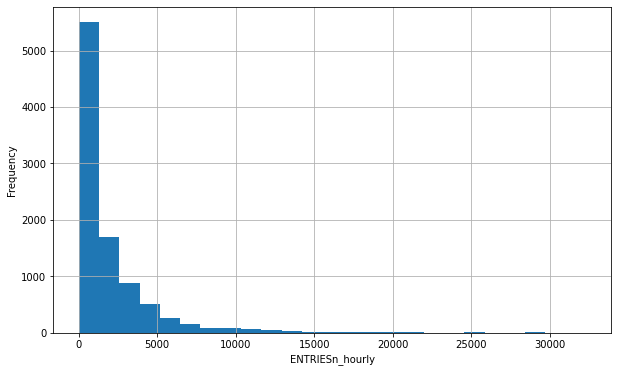

In [ ]:
rain_data['ENTRIESn_hourly'].hist(bins=25, figsize=(10,6))
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

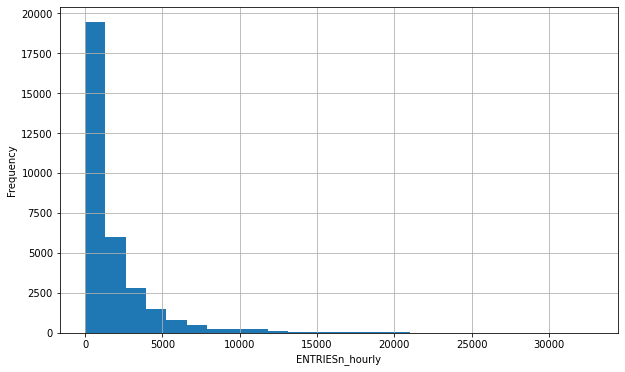

In [ ]:
non_rain_data['ENTRIESn_hourly'].hist(bins=25, figsize=(10,6))
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')

We can see that the amount of entries does not follow normal distribution

> To handle this, I run a non parameter test. A test doesn't assume data fits specific distribution type. I use Kruskal test 

In [ ]:
from scipy import stats
print('Mean entries with rain:', rain_data['ENTRIESn_hourly'].mean())
print('Mean entries without rain:', non_rain_data['ENTRIESn_hourly'].mean())
stats.kruskal(rain_data, non_rain_data)

Mean entries with rain: 2056.7349767245028
Mean entries without rain: 1889.1924458204335


KruskalResult(statistic=10.636631159885614, pvalue=0.0011086945155163392)

> **p_value < 0.05, so I reject Null hypothesis and accept my hypothesis that entries is statistically different between rain and non_rain day**

> So now, We know that raining has affection on the amount of entries 

<Figure size 432x288 with 0 Axes>

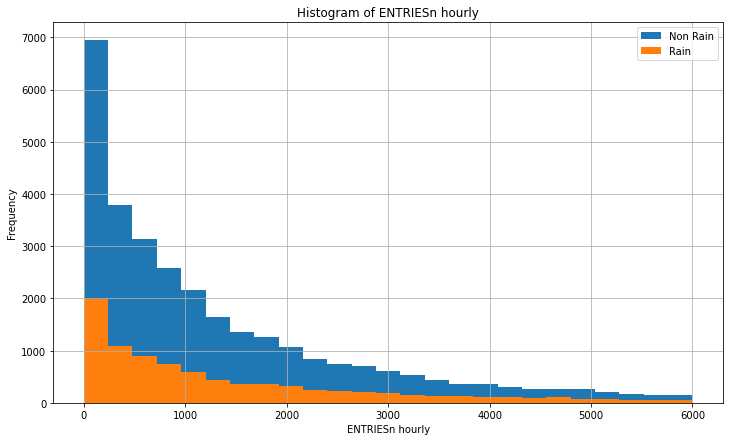

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

non_rain_data['ENTRIESn_hourly'].hist(range = [0, 6000], bins=25, figsize=(12,7), label='Non Rain')
rain_data['ENTRIESn_hourly'].hist(range = [0, 6000], bins = 25, label='Rain')

plt.title('Histogram of ENTRIESn hourly')
plt.xlabel('ENTRIESn hourly')
plt.ylabel('Frequency')
plt.legend()

plt.figure()

### 2. Time of the day effects the amount subway ridership

> Now, we're gonna make assumption of whether time of the day effects the entries

In [ ]:
data['hour'].value_counts()

0     7243
12    7215
20    7210
4     7192
16    7164
8     5728
Name: hour, dtype: int64

Text(0.5, 1.0, 'Mean entries by hour')

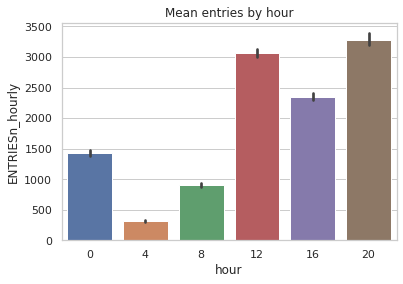

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="hour", y="ENTRIESn_hourly", data=data)
ax.set_title('Mean entries by hour')

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

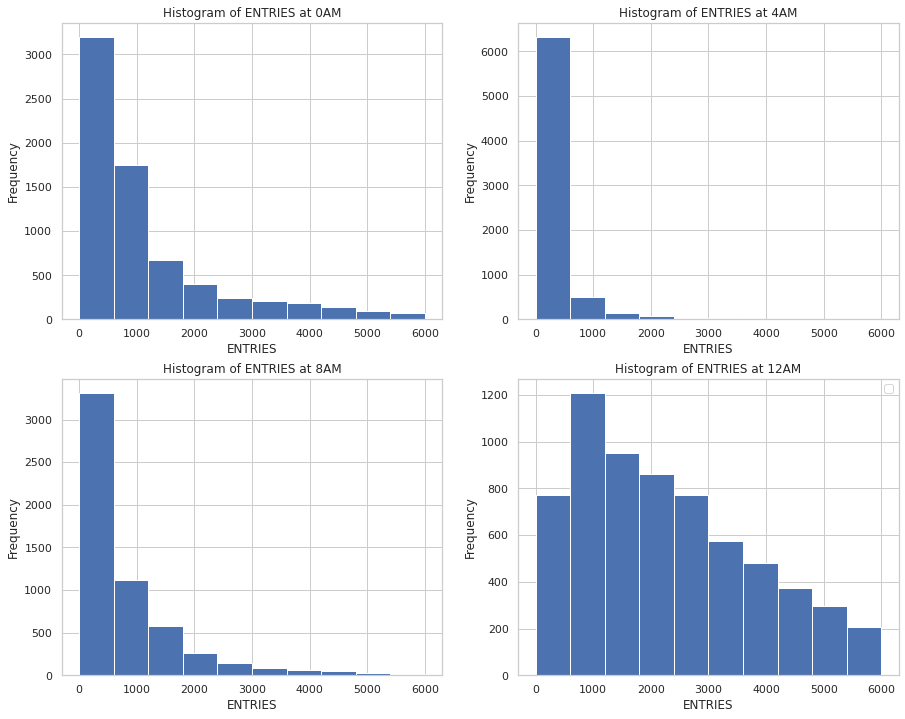

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15,12))

axs[0][0].hist(data[data['hour']==0]['ENTRIESn_hourly'], range=[0,6000])
axs[0][0].set_xlabel('ENTRIES')
axs[0][0].set_ylabel('Frequency')
axs[0][0].set_title('Histogram of ENTRIES at 0AM')

axs[0][1].hist(data[data['hour']==4]['ENTRIESn_hourly'], range=[0,6000])
axs[0][1].set_xlabel('ENTRIES')
axs[0][1].set_ylabel('Frequency')
axs[0][1].set_title('Histogram of ENTRIES at 4AM')

axs[1][0].hist(data[data['hour']==8]['ENTRIESn_hourly'], range=[0,6000])
axs[1][0].set_xlabel('ENTRIES')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_title('Histogram of ENTRIES at 8AM')

axs[1][1].hist(data[data['hour']==12]['ENTRIESn_hourly'], range=[0,6000])
axs[1][1].set_xlabel('ENTRIES')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_title('Histogram of ENTRIES at 12AM')

plt.legend()

plt.figure()

> Entries at different times of day do not follow normal distribution

> So, I use non-parameter test: kruskal test. 

> Null hypotheis: There's no significant different between the means of each group: entries with rain and entries without rain 

> My hypothesis: There's a significant different between the means of each group.





In [ ]:
stats.kruskal(data[data['hour']==0]['ENTRIESn_hourly'],data[data['hour']==4]['ENTRIESn_hourly'], data[data['hour']==12]['ENTRIESn_hourly'])

KruskalResult(statistic=10602.119350986148, pvalue=0.0)

> **My p_value < 0.05 so I reject Null hypothesis and accept the hypothesis that time of the day effects the entries of subway**

### 3. Day of week effects on the amount subway ridership

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Histogram of ENTRIES on Sunday')

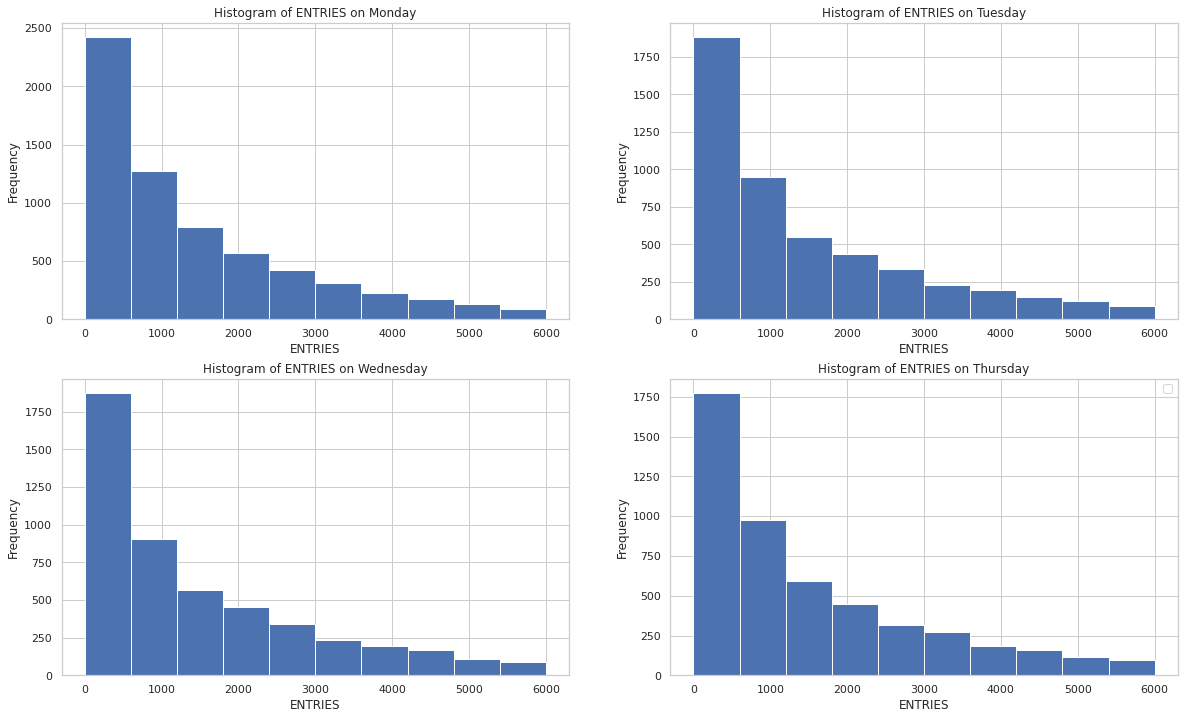

<Figure size 432x288 with 0 Axes>

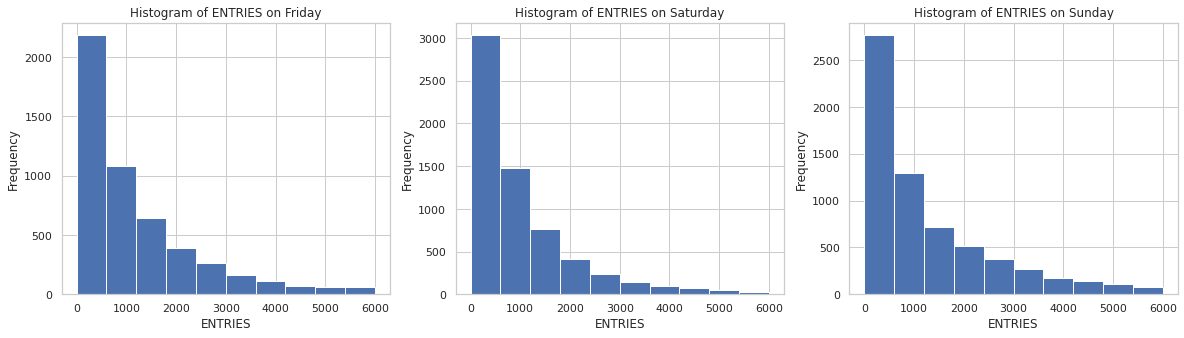

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(20,12))

axs[0][0].hist(data[data['day_week']==1]['ENTRIESn_hourly'], range=[0,6000])
axs[0][0].set_xlabel('ENTRIES')
axs[0][0].set_ylabel('Frequency')
axs[0][0].set_title('Histogram of ENTRIES on Monday')

axs[0][1].hist(data[data['day_week']==2]['ENTRIESn_hourly'], range=[0,6000])
axs[0][1].set_xlabel('ENTRIES')
axs[0][1].set_ylabel('Frequency')
axs[0][1].set_title('Histogram of ENTRIES on Tuesday')

axs[1][0].hist(data[data['day_week']==3]['ENTRIESn_hourly'], range=[0,6000])
axs[1][0].set_xlabel('ENTRIES')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_title('Histogram of ENTRIES on Wednesday')

axs[1][1].hist(data[data['day_week']==4]['ENTRIESn_hourly'], range=[0,6000])
axs[1][1].set_xlabel('ENTRIES')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_title('Histogram of ENTRIES on Thursday')
plt.legend()

plt.figure()

fig, axs = plt.subplots(1,3, figsize=(20,5))

axs[0].hist(data[data['day_week']==5]['ENTRIESn_hourly'], range=[0,6000])
axs[0].set_xlabel('ENTRIES')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of ENTRIES on Friday')

axs[1].hist(data[data['day_week']==6]['ENTRIESn_hourly'], range=[0,6000])
axs[1].set_xlabel('ENTRIES')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of ENTRIES on Saturday')

axs[2].hist(data[data['day_week']==0]['ENTRIESn_hourly'], range=[0,6000])
axs[2].set_xlabel('ENTRIES')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Histogram of ENTRIES on Sunday')

In [ ]:
stats.kruskal(data[data['day_week']==1]['ENTRIESn_hourly'],data[data['day_week']==2]['ENTRIESn_hourly'],data[data['day_week']==3]['ENTRIESn_hourly'], data[data['day_week']==4]['ENTRIESn_hourly'],
              data[data['day_week']==5]['ENTRIESn_hourly'],data[data['day_week']==6]['ENTRIESn_hourly'], data[data['day_week']==0]['ENTRIESn_hourly'])

KruskalResult(statistic=924.1762729610545, pvalue=2.2282889854976663e-196)

>**p_value < 0.05: So I accept the assumption:that entries is statistically different among days of week**

### 4. Station effects on the amount subway ridership

In [ ]:
entries_station = data['station'].value_counts()
print('Top 10 stations have most records:\n','\n'.join(entries_station.index[0:10]))

Top 10 stations have most records:
 34 ST-PENN STA
86 ST
50 ST
LEXINGTON AVE
145 ST
34 ST-HERALD SQ
CHAMBERS ST
42 ST-TIMES SQ
JAY ST-METROTEC
LEXINGTON-53 ST


Text(0.5, 1.0, 'Histogram of ENTRIES at LEXINGTON AVE')

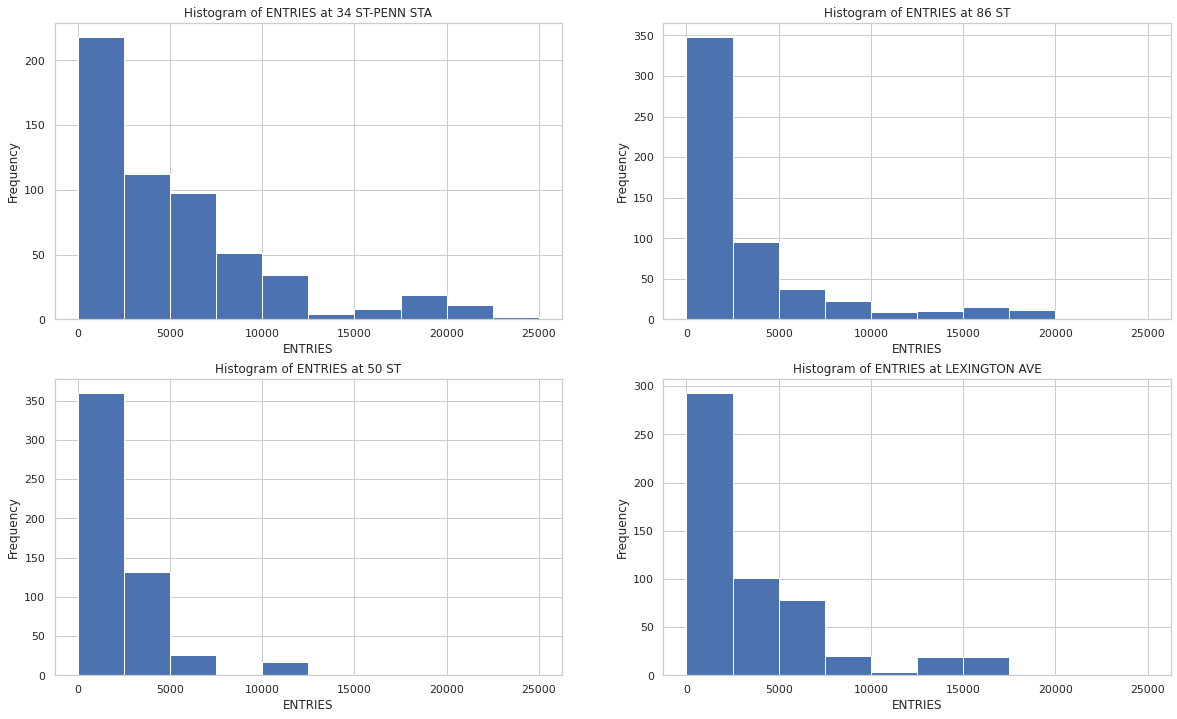

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(20,12))

axs[0][0].hist(data[data['station']=='34 ST-PENN STA']['ENTRIESn_hourly'], range=[0,25000])
axs[0][0].set_xlabel('ENTRIES')
axs[0][0].set_ylabel('Frequency')
axs[0][0].set_title('Histogram of ENTRIES at 34 ST-PENN STA')

axs[0][1].hist(data[data['station']=='86 ST']['ENTRIESn_hourly'], range=[0,25000])
axs[0][1].set_xlabel('ENTRIES')
axs[0][1].set_ylabel('Frequency')
axs[0][1].set_title('Histogram of ENTRIES at 86 ST')

axs[1][0].hist(data[data['station']=='50 ST']['ENTRIESn_hourly'], range=[0,25000])
axs[1][0].set_xlabel('ENTRIES')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_title('Histogram of ENTRIES at 50 ST')

axs[1][1].hist(data[data['station']=='LEXINGTON AVE']['ENTRIESn_hourly'], range=[0,25000])
axs[1][1].set_xlabel('ENTRIES')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_title('Histogram of ENTRIES at LEXINGTON AVE')


> Entries at each station also does not follow normal distribution

In [ ]:
stats.kruskal(data[data['station']=='34 ST-PENN STA']['ENTRIESn_hourly'],data[data['station']=='86 ST']['ENTRIESn'])

KruskalResult(statistic=830.2074526407749, pvalue=1.460721560577897e-182)

> **p_value < 0.05: entries is statistically different among stations**

## So, do more people ride subway on rainy day?

> My answer is yes! Above, I have demonstrate by run hypothesis testing and conclude that there's a significant different between the means of the amount of entries in rainy days and non rainy days.

> But, more or less? The answer is more. By calculating mean, we have entries on rainy day more than 167 people compare with on non rainy days. 

> To see the coefficent effect. I'm gonna build a Linear Regression model

In [ ]:
rain_data.mean() - non_rain_data.mean()

ENTRIESn_hourly    167.542531
dtype: float64



---



# Predict number of entries using Linear Regression

> Now, I'm gonna try to predict the amount of entries using Linear Regression model

### Feature selection

> I'm gonna use: `station`, `hour`, `day_week`, `week_day`, `fog`, `conds`, `rain` to train Linear Regression model

> I use one hot encoding to preresent `station`, `hour`, `conds`, `day_week`

In [ ]:
training_data = pd.DataFrame(data, columns=['station', 'hour', 'day_week','conds','rain','weekday','fog'])
y = data['ENTRIESn_hourly'].values.flatten()

In [ ]:
training_data = pd.get_dummies(training_data,columns=['station','hour', 'day_week', 'conds'])

In [ ]:
training_data.head()

,rain,weekday,fog,station_1 AVE,station_103 ST-CORONA,station_104 ST,station_110 ST,station_110 ST-CPN,station_111 ST,station_121 ST,station_125 ST,station_135 ST,station_138 ST-GR CONC,station_14 ST,station_145 ST,station_148 ST-LENOX,station_149 ST-3 AVE,station_149 ST-GR CONC,station_167 ST,station_168 ST-BROADWAY,station_169 ST,station_170 ST,station_174-175 ST,station_175 ST,station_176 ST,station_18 AVE,station_18 ST,station_181 ST,station_182-183 ST,station_183 ST,station_190 ST,station_191 ST,station_2 AVE,station_20 AVE,station_207 ST,station_21 ST,station_215 ST,station_23 ST,station_23 ST-5 AVE,station_23 ST-6 AVE,...,station_SUTPHIN BLVD,station_SUTTER AVE,station_UNION ST,station_VAN SICLEN AVE,station_VAN WYCK BLVD,station_VERNON/JACKSON,station_W 8 ST-AQUARIUM,station_WALL ST,station_WASHINGTON-36 A,station_WESTCHESTER SQ,station_WHITLOCK AVE,station_WILSON AVE,station_WOODHAVEN BLVD,station_WOODLAWN ROAD,station_WORLD TRADE CTR,hour_0,hour_4,hour_8,hour_12,hour_16,hour_20,day_week_0,day_week_1,day_week_2,day_week_3,day_week_4,day_week_5,day_week_6,conds_Clear,conds_Fog,conds_Haze,conds_Heavy Rain,conds_Light Drizzle,conds_Light Rain,conds_Mist,conds_Mostly Cloudy,conds_Overcast,conds_Partly Cloudy,conds_Rain,conds_Scattered Clouds
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
training_data.shape

(41752, 234)

> After one hot encoding, we have `234 features`

> To correctly evaluate model, I divide my training data into two sets: Train set: 0.8 and Test set:0.2 Training model on train set and Evaluating model on test set

### Train and evaluate

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_data, y, test_size=0.2, random_state=7, shuffle=True, stratify=None)

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.coef_[0])

0.5063719747606412
106.77372958614447


> I get 0.506 R-square score on test set. Its mean Linear Regression can explain about 50 percent of data 

> The coefficent of `rain` feature is 106. It means, when its raining the entries increase 106 people. Because our feature value is 1 for raining.

# Use GradientBoostingRegressor to improve prediction performance 

> To improve prediction performance. I use GradientBoostingRegressior. 

> This time, I use more features

### Feature selection

> I drop UNIT and feature related to date and time. 

In [ ]:
training_data = data.drop(columns=['UNIT','DATEn','TIMEn','EXITSn','ENTRIESn','ENTRIESn_hourly','EXITSn_hourly','datetime'])
target = data[['ENTRIESn_hourly']]
target = target.values.flatten()

In [ ]:
training_data.columns

Index(['hour', 'day_week', 'weekday', 'station', 'conds', 'fog', 'precipi',
       'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', 'meanpressurei',
       'meantempi', 'meanwspdi'],
      dtype='object')

In [ ]:
training_data = pd.get_dummies(training_data, columns = ['station','hour','day_week','conds'])

In [ ]:
training_data.shape

(41752, 242)

In [ ]:
learning_rate=[0.01]
alpha=[0.01,0.03,0.05,0.1,0.3, 0.9]
n_estimators=[int(x) for x in np.linspace(start = 100, stop = 500, num = 4)]
max_depth=[int(x) for x in np.linspace(start = 10, stop = 30, num = 4)]
max_depth.append(None)
min_samples_split=[int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
min_samples_leaf=[int(x) for x in np.linspace(start = 1, stop = 4, num = 4)]
max_features=['auto', 'sqrt']

# Create the random grid
param_grid = {'learning_rate':learning_rate,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             }
# Initialize and fit the model.
model = GradientBoostingRegressor()
model = RandomizedSearchCV(model, param_grid, cv=3)
model.fit(X_train, y_train)

# get the best parameters
best_params = model.best_params_
print(best_params)

{'n_estimators': 233, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'learning_rate': 0.01, 'alpha': 0.05}


In [ ]:
model_best = GradientBoostingRegressor(**best_params)
model_best.fit(X_train,y_train)
y_pred = model_best.predict(X_test)

In [ ]:
X_test.shape

(10438, 236)

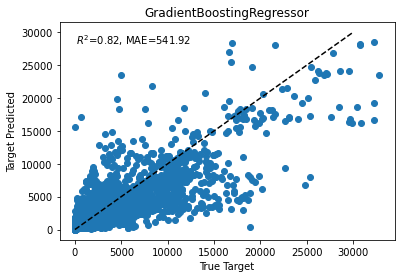



R-squared test set:
0.8248261834136358

MAE test set: 
940.8436721224815

MSE test set: 
2940218.9953165273


In [ ]:
plt.scatter(y_test,y_pred)
plt.plot([0,30000],[0,30000],'--k')
plt.ylabel('Target Predicted')
plt.xlabel('True Target')
plt.title('GradientBoostingRegressor')
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 + data_width*0.05, y0 + data_height * 0.9, r'$R^2$=%.2f, MAE=%.2f' % (model_best.score(X_train, y_train), median_absolute_error(y_test, y_pred)))
plt.show()
print('\n\nR-squared test set:')
print(model_best.score(X_train, y_train))
print('\nMAE test set: ')
print(mean_absolute_error(y_test, y_pred))
print('\nMSE test set: ')
print(mean_squared_error(y_test, y_pred))

> My model reachs 0.825 R-square. It means 82 percent of my test data can be explained by my model. Preety good!


In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


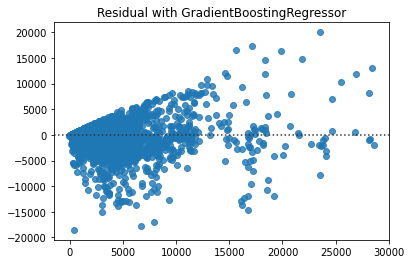

In [ ]:
resid = y_pred - y_test
sns.residplot(y_pred, resid)
plt.title('Residual with GradientBoostingRegressor')
plt.show()

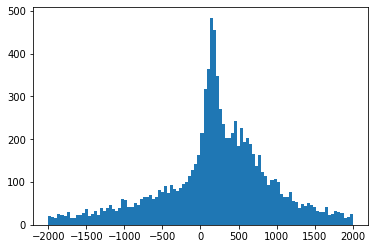

In [ ]:
plt.hist(resid, bins=100, range=[-2000,2000])
plt.show()

> Residual quiet follow normal distribution, so I can accept that my model can explaned 84% on population

# Conclusion

> Based on this analysis, the amount of subway ridership increases when it's raining:

>> By calculating the difference mean of the amount of entries. I get that it increases 167 on average the amount of entries on rainy day. 

>> I have run a hypothesis test to determine whether there's a significant different between means of `ENTRIES_hourly` on rainy and non rainyday. And the result is yes, there is a significant different between means of two groups

>> I use Linear Regression to predict the entries and I get the coefficent of the `rain` feature is 106. It means there are 106 more people ride subwway on rainy day

> Beside the rain, obviously, `hour of the day`, `day of week` or `station` also effect on the amount of people riding subway. But this is more easier to understand, example: with the `hour of day`, its likely more people get to work on 12PM for the day shift and 20PM for the night shift